## 0. Imports, Constants, Example Dataset

In [1]:
# Basic boilerplate imports
import numpy as np
import pandas as pd
import yaml, os, sys, re
from tqdm import tqdm
import copy
import json
orig_stdout = sys.stdout

# Plotting needs
from plotly.offline import iplot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from plotly import graph_objs as go
from plotly.subplots import make_subplots

#Stat needs
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree

# Set lartpc_mlreco3d path
SPINE_PATH = "/sdf/data/neutrino/software/spine/"
sys.path.append(SPINE_PATH)

# SPINE functions
from spine.driver import Driver
from spine.utils.globals import *
from spine.vis.layout import layout3d, HIGH_CONTRAST_COLORS
from spine.vis import scatter_points, scatter_particles
from spine.vis.geo import GeoDrawer
#from spine.utils.geo import Geometry
#from spine.data.batch import TensorBatch

Welcome to JupyROOT 6.26/16


In [2]:
#Physics constants
VDRIFT = 1.563 #drift velocity in SBND [mm/us]

#Config
MAKE_PLOTS = False
SAVE_PLOTS = False
DATA_PATH = '/sdf/data/neutrino/bearc/larcv/v10_04_01_mpvmpr_intime/spacepoint_params/doublet/10event'
CFG_PATH = 'supera.cfg'
EVENT_ID = 3

#SBND geometry
#detector = Geometry('sbnd').detector.T

#Parameters for classifying a Cluster3D point as a non-ghost point using truth information (more info in 1.2.4)
sbnd_nominal_params = {
    'ne': 175,    #number of electrons
    'tw': 15,     #tick window
    'pa': 0.7,    #post averaging threshold (cm)
    'vd': 3       #voxel distance threshold = tw/5 (voxels)
}

### 0.1 Functions

In [3]:
def get_larcv_fname(params):
    """
    Docstring generated using AI. 
    
    Generate a filename for larcv based on given parameters.
    
    Parameters
    ----------
    params : dict
        A dictionary containing the parameters for generating the filename.
        Expected keys are:
        - 'ne': str or float
        - 'pa': str or float
        - 'tw': str or float
        - 'vd': str or float
    
    Returns
    -------
    str
        Filename in the format 'larcv_ne{ne}_pa{pa}_tw{tw}_vd{vd}.root'.
    """
    return f"larcv_ne{params['ne']}_pa{int(params['pa']*1e3)}_tw{params['tw']}_vd{params['vd']}.root" 
def extract_larcv_params(fname):
    """
    Extracts the parameters from a filename generated by get_larcv_fname function.
    
    Parameters
    ----------
    fname : str
        The filename to extract parameters from.
    
    Returns
    -------
    dict
        A dictionary containing the extracted parameters from the filename.
        Keys:
        - 'ne': float
        - 'pa': float
        - 'tw': float
        - 'vd': float
    """
    # Define the pattern to extract parameters from the filename
    pattern = r'larcv_ne(\w+)_pa(\w+)_tw(\w+)_vd(\w+)\.root'

    # Use re.search to find the parameters in the filename
    match = re.search(pattern, fname)

    # Extract the parameters into a dictionary if a match is found
    if match:
        params = {
            'ne': float(match.group(1)),
            'pa': float(match.group(2))*1e-3,
            'tw': float(match.group(3)),
            'vd': float(match.group(4))
        }
        return params
    else:
        return None
def prepare_event(event,detector_coords=True):
    """
    Convert to detector coordinates (or pixel coords if false)
    """
    meta = event['meta'][0] #assume same bounding box
    event['input_data'].to_cm(meta)
    event['cluster_label'].to_cm(meta)
    event['sed'].to_cm(meta)
    event['particles_label'].to_cm(meta)
    return event

### 0.2 SBND MPVMPR simulation using nominal spacepoint parameters (see 3.5 for more info)

In [4]:
#Load event / event ID
fname = get_larcv_fname(sbnd_nominal_params)
_cfg = yaml.safe_load(open(CFG_PATH, 'r').read().replace('FNAME', f'{DATA_PATH}/{fname}')\
                      .replace('EVENT_ID',str(EVENT_ID))) #load event specified

# prepare function configures necessary "handlers"
driver = Driver(_cfg)

#Parse data
event_nominal = driver.process()

#Copy and convert to detector coords
event_nominal_pix = copy.deepcopy(event_nominal) #copy before converting
event_nominal = prepare_event(event_nominal)


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.6.0

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfiana008 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {world_size: 0, seed: 1758753679}
io:
  loader:
    batch_size: 4
    shuffle: false
    num_workers: 4
    collate_fn: all
    dataset:
      name: LArCVDataset
      file_keys: /sdf/data/neutrino/bearc/larcv/v10_04_01_mpvmpr_intime/spacepoint_params/doublet/10event/larcv_ne175_pa700_tw15_vd3.root
      entry_list: [3]
      schema:
        input_data:
          parser: sparse3d
          args:
            sparse_event_list: [sparse3d_reco, sparse3d_reco_chi2, sparse3d_reco_hit_charge0,
 

Will load 1 file(s):
 - /sdf/data/neutrino/bearc/larcv/v10_04_01_mpvmpr_intime/spacepoint_params/doublet/10event/larcv_ne175_pa700_tw15_vd3.root

Loading tree sparse3d_reco
Loading tree sparse3d_reco_chi2
Loading tree sparse3d_reco_hit_charge0
Loading tree sparse3d_reco_hit_charge1
Loading tree sparse3d_reco_hit_charge2
Loading tree sparse3d_reco_hit_key0
Loading tree sparse3d_reco_hit_key1
Loading tree sparse3d_reco_hit_key2
Loading tree sparse3d_pcluster_semantics_ghost
Loading tree sparse3d_pcluster
Loading tree particle_corrected
Loading tree particle_pcluster
Loading tree cluster3d_pcluster
Loading tree neutrino_mpv
Loading tree sparse3d_pcluster_semantics
Loading tree sparse3d_reco_rescaled
Loading tree cluster3d_sed

Total number of entries in the file(s): 10

Total number of entries selected: 1



In [6]:
#Camera/scene config
camera = dict(up=dict(x=0, y=1, z=0),center=dict(x=0, y=0, z=0),eye=dict(x=1.25, y=1.25, z=1.25))
layout = layout3d(detector='sbnd', detector_coords=True, camera=camera, showlegend=False)

tpc_traces = GeoDrawer('sbnd').tpc_traces(draw_faces=False, linewidth=5)

## 1. Supera

<div>
    <span style="font-size: 36px; font-weight: bold;">Which of these is Supera?</span>
    <br>
    <img src="assets/supra.jpg" width="500"/>
    <img src="assets/dogs.jpg" width="400"/>
    
</div>

<div>
    <span style="font-size: 36px; font-weight: bold;">It's actually neither!</span>
    <br>
    <span style="font-size: 18px;font-weight: bold;">Supera (for LArTPC experiments) is NOT a car or two puppies!! </span>
    <span style="font-size: 18px;">Supera in our case creates labels from truth information created by the particle generator (MPVMPR in our case) and the particle propagation simulation (Geant4 in our case).</span>
    <br><br>
    <img src="assets/supera.jpg" width="500"/>
</div>

<br>

Supera uses the [IOManager](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/DataFormat/IOManager.h) from `larcv2` to configure, run, and save the output of a list of processes for the [ProcessDriver](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/Processor/ProcessDriver.h). Canonically, the processes consume truth information to **make labels** and **saves reconstructed information** from the subsytems (TPC, CRT, PDS) into a TTree, named `larcv.root`.

See example [SBND mpvmpr supera configuration](https://github.com/DeepLearnPhysics/Supera/blob/icarus/job/supera_sbnd_mpvmpr.fcl) for details on variables.



## 2. Process Driver

The process driver calls all of the processes necessary to label the data and save the reconstructed values. Let's take a look at each one one-by-one!

```bash
ProcessDriver: {

  ...
  ProcessType:  ["SuperaMCTruth","SuperaBBoxInteraction","SuperaMCParticleCluster","SuperaSimEnergyDeposit","SuperaSpacePoint","SuperaOptical","Tensor3DFromCluster3D","CombineTensor3D","ThresholdTensor3D","CombineTensor3D","ParticleCorrector","EmptyTensorFilter","RescaleChargeTensor3D"]
  ProcessName:  ["MultiPartVrtx","SuperaBBoxInteraction","SuperaMCParticleCluster","SuperaSimEnergyDeposit","SuperaSpacePoint","SuperaOptical","Tensor3DFromCluster3D","CombineTensor3DGhost","ThresholdTensor3D","CombineTensor3D","ParticleCorrector","EmptyTensorFilter","RescaleChargeTensor3D"]
  ...
}

```

To run code to produce LArCV files from simulation files with space point products, we use `lar`

```
lar -c run_*.fcl -s stage.root
```
Where `stage` is - 
- `stage1` files (with SpacePoint data products) files in LArSoft (ICARUS)
- `reco1` files (with SpacePoint data products) files in LArSoft (SBND)

See SBN's Supera configurations [here](https://github.com/DeepLearnPhysics/Supera/tree/develop/job)

## 3. Processes

### 3.1 Supera MCTruth

The `MCTruthProducers` come from the *larsoft data product handles*, see [this fcl](https://github.com/SBNSoftware/sbndcode/blob/f55a60bb1d9f5196bc645ce1b645ab67cffb857f/sbndcode/JobConfigurations/standard/gen/MultiPart/run_mpvmpr_sbnd.fcl#L31-L37) to see where they're produced.

Example for MPVMPR.

```bash
MultiPartVrtx: {
  Verbosity: 2
  MCTruthProducers: ["generator","rain","rain2"]
  OutParticleLabel: "mpv"
  Origin: 0
}
```

Example for [neutrino generator](https://github.com/DeepLearnPhysics/Supera/blob/a0dfe1b06a171f271e7605dab9b67d110fc6cf51/job/supera_sbnd_corsika.fcl#L96C1-L102C6).

```bash
MultiPartVrtx: {
  Verbosity: 2
  LArMCTruthProducer: "generator"
  OutParticleLabel: "mpv"
  Origin: 0
}
```

`neutrino_*` refers to a [larcv::EventNeutrino](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/DataFormat/EventNeutrino.h#L26), a list of [larcv::Neutrino](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/DataFormat/Neutrino.h#L27) objects
  - Each `Neutrino` object has a bunch  of MC truth neutrino level attributes
  - E.g. vertex, interaction type (CC, NC), neutrino energy, etc.

### 3.2 SuperaBBox Interaction

Sets voxel meta data like the voxel size, TPCs, Cryostats, and the bounding box containing all valid voxels.

Example for SBND

```bash
SuperaBBoxInteraction: {
  Verbosity: 2
  LArMCTruthProducer: "generator"
  LArSimEnergyDepositLiteProducer: "sedlite"
  UseSEDLite: true
  Origin: 0
  Cluster3DLabels: ["mcst","pcluster","sed","masked_true2reco"]
  Tensor3DLabels:  ["reco","pcluster_index","masked_true"]
  BBoxSize: [614.4, 614.4, 614.4] # 2048 pixels of 0.3 mm
  BBoxBottom: [-307.2, -307.2, -57.4] # centered on the detector center with some padding - [400,400,500] cm active volume
  VoxelSize: [0.3,0.3,0.3]
  UseFixedBBox: true
  CryostatList: [0,0] #single cryostat
  TPCList: [0,1] #two tpcs
}
```

In [7]:
event_nominal['meta'][0]

Meta(lower=array([-307.2, -307.2,  -57.4], dtype=float32), upper=array([307.2, 307.2, 557. ], dtype=float32), size=array([0.3, 0.3, 0.3], dtype=float32), count=array([2048, 2048, 2048]))

### 3.3 SuperaSimEnergyDeposit

Stores `SimEnergyDeposit` points and values. Assigns `trackID` to associate with `MCParticle`.

Example for SBND
```bash
SuperaSimEnergyDeposit: {
  Verbosity: 2
  LArSimEnergyDepositLiteProducer: "sedlite"
  LArMCShowerProducer: "mcreco"
  UseSEDLite: true
  ParticleProducer: "pcluster"
  OutCluster3DLabel: "sed"
  StoreLength: false
  StoreCharge: false
  StorePhoton: false
  StoreDiffTime: false
  StoreAbsTime: true
  StoreDEDX: false
  TPCList: [0,1]
  CryostatList: [0,0]
}
```

In [8]:
sed_nominal = event_nominal['sed'].tensor #sim energy deposits (from geant4) in voxel coords
particles_nominal = event_nominal['particles_asis'][0] #particles (from geant4) in voxel coords

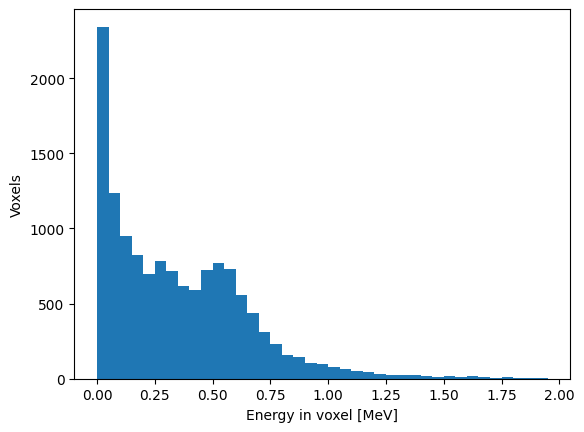

In [9]:
#SED point visualization
plt.hist(sed_nominal[:,VALUE_COL],bins=np.arange(0,2,0.05))
plt.xlabel('Energy in voxel [MeV]')
plt.ylabel('Voxels');

In [11]:
#Visualize energy depositions from various particles
sed_graph = tpc_traces
#sed_graph += scatter_points(sed_nominal[:,COORD_COLS],sed_nominal[:,-1],colorscale='rainbow',markersize=1) 
sed_graph += scatter_points(event_nominal['sed'].data[:,COORD_COLS],event_nominal['sed'].data[:,VALUE_COL],colorscale='Inferno',markersize=1,cmax=1.,cmin=0)
sed_graph[-1]['name'] = 'SED'

fig = go.Figure(sed_graph, layout=layout)
fig.update_layout(showlegend=True)
if MAKE_PLOTS:
    iplot(fig)
if SAVE_PLOTS:
    fig.write_image('figures/event_sbnd_sed.png')

### 3.4 SuperaSpacePoint

Stores reconstructed space points made by `Cluster3D`.

Example for SBND
```bash
SuperaSpacePoint: {
  Verbosity: 2
  SpacePointProducers: ["cluster3d"]
  OutputLabel:        "reco"
  DropOutput: ["hit_amp","hit_rms","hit_mult"]
  StoreWireInfo: true
  RecoChargeRange: [-1000, 50000]
}
```

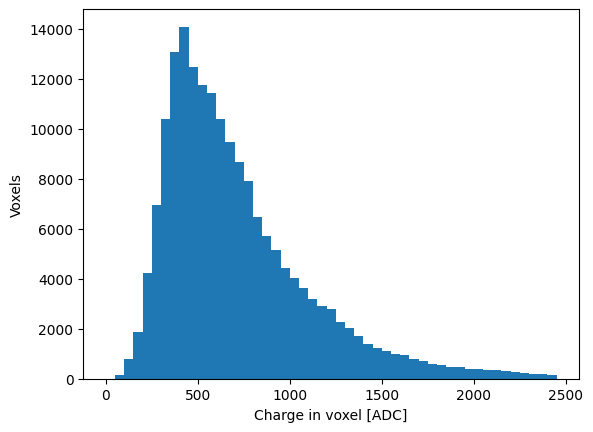

In [12]:
input_data = event_nominal['input_data'].tensor #Input space points
raw_charge = input_data[:, VALUE_COL] #Charge before pitch correction

plt.hist(raw_charge,bins=np.arange(0,2500,50))
plt.xlabel('Charge in voxel [ADC]')
plt.ylabel('Voxels');

In [ ]:
#Cluster3D point visualization - why is colorscale not working??
tpc_traces = GeoDrawer('sbnd').tpc_traces(draw_faces=False, linewidth=5)
graph = []
graph += tpc_traces

graph += scatter_points(input_data[:, COORD_COLS], color=raw_charge, colorscale='Inferno', cmax=500, markersize=1)
graph[-1]['name'] = 'Raw charge'
# graph += scatter_points(input_data[:, COORD_COLS], color=event_nominal['input_data'].tensor[:,5], colorscale='Inferno', cmax=10, markersize=1)
# graph[-1]['name'] = 'Chi2'

fig = go.Figure(graph, layout=layout)
fig.update_layout(showlegend=True)
#if True:
if MAKE_PLOTS:
    iplot(fig)
if SAVE_PLOTS:
    fig.write_image('figures/event_sbnd_spacepoint.png')

### 3.5 SuperaMCParticleCluster

Assigns particle clusters for the particle and interaction for both GrapPA networks. It **heavily** relies on the `trackID` attribute being properly filled from a common source, usually Geant4. It also assigns the truth labels of reconstructed space points created in `Cluster3D`.

<div>
    <span style="font-size: 24px; font-weight: bold;">Data products for truth info</span>
</div>

- [SimChannel](https://internal.dunescience.org/doxygen/classsim_1_1SimChannel.html) - Contains the energy deposited per voxel and `trackID` of particle that deposited that energy. Filled from drift simulation.
- [MCParticle](https://internal.dunescience.org/doxygen/classsimb_1_1MCParticle.html) - Particles stored from Geant4 propagation. You will need to make sure secondary particles (i.e. from electromagnetic shower daughters) are also stored in the same list. 
- [SimEnergyDepositLite](https://sbnsoftware.github.io/doxygen/db/d64/SimEnergyDepositLite_8h.html) - Contains the energy deposited per voxel and `trackID` of particle that deposited that energy. From Geant4, *future Supera versions will replace this with SimChannel*.
- [MCTrack](https://github.com/LArSoft/lardataobj/blob/4dee2ea18f5d016ec0e65f7566a722cb37d081a2/lardataobj/MCBase/MCTrack.h) & [MCShower](https://github.com/LArSoft/lardataobj/blob/4dee2ea18f5d016ec0e65f7566a722cb37d081a2/lardataobj/MCBase/MCShower.h) - LArTPC specific particle objects used to track ancestory from primary. Contains `trackID` information about the the particle's mother and primary ancestor. 

<br>

**WARNING!!!** - "In house" particle propagation tools have a tendency to overwrite `trackID` with their own values so be careful that the trackIDs you're using is from the correct source. For example `SimChannel` has an attribute called `origTrackID` which contains the `trackID` from Geant4, which is the one you actually need!

<div>
    <span style="font-size: 24px; font-weight: bold;">Data products for reco info</span>
</div>



Example from SBND

```bash
SuperaMCParticleCluster: {
  OutputLabel: "pcluster"
  LArMCParticleProducer: "simplemerge" # produced when merging from previous stage
  LArMCShowerProducer: "mcreco"
  LArMCTrackProducer:  "mcreco"
  DeltaSize: 10
  LArSimEnergyDepositLiteProducer: "sedlite"
  Meta3DFromCluster3D: "mcst"
  Meta2DFromTensor2D:  ""
  Verbosity: 2
  UseSimEnergyDeposit: false #AnalyzeSimEnergyDeposit if true, else AnalyzeFirstLastStep - default false
  UseSimEnergyDepositLite: false 
  UseSimEnergyDepositPoints: false
  UseOrigTrackID: true #SUPER IMPORTANT
  CryostatList: [0,0]
  TPCList: [0,1]
  PlaneList: []
  SemanticPriority: [1,2,0,3,4] # 0-4 for shower track michel delta LE-scattering
  CheckParticleValidity: false #set false, but this needs to be checked later
  SuperaTrue2RecoVoxel3D: {
    UseOrigTrackID: true
    DebugMode: true
    Profile: true
    Verbosity: 2
    Meta3DFromCluster3D: "pcluster"
    LArSimChProducer: "simtpc2d simpleSC"
    LArSpacePointProducers: ["cluster3d"]
    OutputTensor3D:  "masked_true"
    OutputCluster3D: "masked_true2reco"
    TwofoldMatching: true
    UseTruePosition: true
    HitThresholdNe: 175
    HitWindowTicks: 5 #15
    HitPeakFinding: false
    PostAveraging: true
    PostAveragingThreshold_cm: 0.425
    DumpToCSV: false
            RecoChargeRange: [-1000,50000]
            VoxelDistanceThreshold: 1. #3
  }
}
```

In [14]:
#Cluster label
cluster_nominal = event_nominal['cluster_label'].tensor

In [15]:
#Visualization of labels
tpc_traces = GeoDrawer('sbnd').tpc_traces(draw_faces=False, linewidth=5)
graph = scatter_particles(cluster_nominal,particles_nominal) #display all labels
graph += tpc_traces

fig = go.Figure(graph, layout=layout)
fig.update_layout(showlegend=True)
if MAKE_PLOTS:
    iplot(fig)
if SAVE_PLOTS:
    fig.write_image('figures/event_sbnd_truth.png')

##### 3.5.1. **SuperaTrue2RecoVoxel3D param search**

Parameters to accept reco voxels. Applies threshold cuts based on following metrics - 
* `Hit number of electrons (Ne)` - Minimum number of electrons within tick window threshold
* `Tick window threshold (tw)` - Time window to accept Ne
* `Voxel distance threshold (vd)` - Conversion between tick window and drift velocity = tw/5
* `Post averaging threshold (pa)` - Lists associated reco voxels, splits true energy evenly between all of them, accepts reco voxels within radius of centroid of associated voxels

The study can be automated for several combinations of parameters. For production of files, see [here](https://github.com/bear-is-asleep/supera_spacepoint_prod/tree/main). The study itself is done in [this notebook](https://github.com/bear-is-asleep/supera_spacepoint/blob/main/spacepoint_params.ipynb).

**Matching voxels**

Use cKDTree to match voxels. cKDTree[1] spatially partitions recursively and stores points in a tree. Query returns $k$ nearest points (index from the array) and the distances to them. We can then specify the `matching threshold` to accept them as a match.

**Purity/Efficiency**

`Purity` describes how many reco voxels are within the matching threshold of a true voxel. `Efficiency` describes how many true voxels are within the matching threshold of a reco voxel.

`purity` =     `reco tagged` / `reco`

`efficiency` = `true tagged` / `true`

[1] https://ceur-ws.org/Vol-2786/Paper28.pdf

In [16]:
def reco_and_true_matching(reco_noghost,true,distance=0):
  """
  Calculates purtiy and efficiency by matching true voxel locations to reco voxel locations
  and vise-versa


  reco_noghost = xyz coords for nonghost
  true         = xyz for true parts
  distance     = threshold distance between voxels

  eff                 = true tagged voxel count / true voxel count
  pur                 = reco tagged voxel count / reco voxels (noghost)
  reco_tagged         = reco voxels that were matched to a true voxel (true->reco)
  true_tagged         = true voxels that were matched to a reco voxel (reco->true)
  reco_reverse_tagged = reco voxels that were matched to a true voxel (reco->true)
  """
  small = 1e-5 #offset for float precision
  tree = cKDTree(true) #Get tree to perform query
  #Return closest distance to each reco point, and indices of that voxel in the truth array
  distances, indices = tree.query(reco_noghost,k=1)
  reco_indices = []
  for i,d in enumerate(distances): #distances from nearest true voxel
      d-=small
      if d<=distance: #Ignore elements that don't satisfy distance threshold
          reco_indices.append(i)
  reco_tagged = reco_noghost[np.unique(reco_indices)]
  pur = len(reco_tagged)/len(reco_noghost)

  #Do it again for efficiency
  tree = cKDTree(reco_noghost) #Get tree to perform query
  #Return closest distance to each reco voxel, and indices of that voxel in the truth array
  distances, indices = tree.query(true,k=1) #Distance from reco to true voxels
  true_indices = []
  reco_tagged_indices = [] #additional index set to store reco points that were matched to true
  for i,d in enumerate(distances):
      d-=small
      if d<=distance: #Ignore elements that don't satisfy the criteria
          true_indices.append(i)
          reco_tagged_indices.append(indices[i])
  reco_reverse_tagged = reco_noghost[np.unique(reco_indices)] #Matched from truth voxel
  true_tagged = true[np.unique(true_indices)]
  eff = len(true_tagged)/len(true)

  return pur,eff,reco_tagged,true_indices,reco_tagged_indices,reco_reverse_tagged,reco_indices

In [17]:
#Compare a set of known bad parameter set and good parameter set
bad_params = {
    'ne': 175,    #number of electrons
    'tw': 20,      #tick window 
    'pa': 0.3,  #post averaging threshold (cm)
    'vd': 4       #voxel distance threshold = tw/5 (voxels)
}

bad_fname = get_larcv_fname(bad_params)
_cfg = yaml.safe_load(open(CFG_PATH, 'r').read().replace('FNAME', f'{DATA_PATH}/{bad_fname}')\
                      .replace('EVENT_ID',str(EVENT_ID))) #load event specified

# prepare function configures necessary "handlers"
driver = Driver(_cfg)

#Parse data
event_bad = driver.process()

# Load a specific event
event_bad_pix = copy.deepcopy(event_bad)

#Convert to detector coordinates
event_bad = prepare_event(event_bad)


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.6.0

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfiana008 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {world_size: 0, seed: 1758753813}
io:
  loader:
    batch_size: 4
    shuffle: false
    num_workers: 4
    collate_fn: all
    dataset:
      name: LArCVDataset
      file_keys: /sdf/data/neutrino/bearc/larcv/v10_04_01_mpvmpr_intime/spacepoint_params/doublet/10event/larcv_ne175_pa300_tw20_vd4.root
      entry_list: [3]
      schema:
        input_data:
          parser: sparse3d
          args:
            sparse_event_list: [sparse3d_reco, sparse3d_reco_chi2, sparse3d_reco_hit_charge0,
 

In [18]:
#Matching threshold
distance = 3 #Euclidean distance - voxels touching by a corner are considered matched

In [19]:
#Poorly tuned supera parameters
seg_label_bad = event_bad_pix['segment_label'].tensor[:,-1]
ghost_mask_bad = seg_label_bad == GHOST_SHP
reco_noghost_bad = event_bad_pix['input_data'].tensor[~ghost_mask_bad,1:4]
sed_bad = event_bad_pix['sed'].data

pur_bad,eff_bad,reco_tagged_bad,true_indices_bad,reco_tagged_indices_bad,reco_reverse_tagged_bad,reco_indices_bad =\
  reco_and_true_matching(reco_noghost_bad,sed_bad[:,1:4],distance=distance)

#Get points using indices
reco_tagged_bad = reco_noghost_bad[reco_tagged_indices_bad]
true_tagged_bad = sed_bad[true_indices_bad]

In [20]:
#SBND tuned supera parameters
seg_label_good = event_nominal_pix['segment_label'].tensor[:,-1]
ghost_mask = seg_label_good == GHOST_SHP
reco_noghost_good = event_nominal_pix['input_data'].tensor[~ghost_mask,1:4]
sed_good = event_nominal_pix['sed'].data

pur_good,eff_good,reco_tagged_good,true_indices_good,reco_tagged_indices_good,reco_reverse_tagged_good,reco_indices_good =\
  reco_and_true_matching(reco_noghost_good,sed_good[:,1:4],distance=distance)

#Get points using indices
reco_tagged_good = reco_noghost_good[reco_tagged_indices_good]
true_tagged_good = sed_good[true_indices_good]

In [21]:
print(f'Purity = {pur_good:.3f} and efficiency = {eff_good:.3f} for nominal params {sbnd_nominal_params}')
print(f'Purity = {pur_bad:.3f} and efficiency = {eff_bad:.3f} for poorly tuned params {bad_params}')

Purity = 0.950 and efficiency = 0.805 for nominal params {'ne': 175, 'tw': 15, 'pa': 0.7, 'vd': 3}
Purity = 0.983 and efficiency = 0.772 for poorly tuned params {'ne': 175, 'tw': 20, 'pa': 0.3, 'vd': 4}


In [22]:
#Make traces for bad and good parameters
traces_bad = []

traces_bad += scatter_points(sed_bad,opacity=0.1,color='green',markersize=1)
traces_bad[-1].name = f'SED voxels'
traces_bad += scatter_points(event_bad_pix['input_data'].tensor[~ghost_mask_bad],opacity=0.1,color='blue',markersize=1)
traces_bad[-1].name = f'Cluster3D points (no ghost)'
traces_bad += scatter_points(true_tagged_bad,opacity=0.6,color='red',markersize=1)
traces_bad[-1].name = f'True tagged voxels'
traces_bad += scatter_points(reco_tagged_bad,opacity=0.6,color='orange',markersize=1)
traces_bad[-1].name = f'Reco tagged voxels'
# traces_bad += scatter_points(event_bad_pix['input_data'][ghost_mask_bad],opacity=0.2,color='red',markersize=1)
# traces_bad[-1].name = f'Cluster3D points (ghost)'

traces_good = []

traces_good += scatter_points(sed_good,opacity=0.1,color='green',markersize=1)
traces_good[-1].name = f'SED voxels'
traces_good += scatter_points(event_nominal_pix['input_data'].tensor[~ghost_mask],opacity=0.1,color='blue',markersize=1)
traces_good[-1].name = f'Cluster3D points (no ghost)'
traces_good += scatter_points(true_tagged_good,opacity=0.6,color='red',markersize=1)
traces_good[-1].name = f'True tagged voxels'
traces_good += scatter_points(reco_tagged_good,opacity=0.6,color='orange',markersize=1)
traces_good[-1].name = f'Reco tagged voxels'
# traces_good += scatter_points(event_nominal_pix['input_data'][ghost_mask],opacity=0.2,color='red',markersize=1)
# traces_good[-1].name = f'Cluster3D points (ghost)'

In [23]:
# Side-by-side event displays for sed vs. ghost
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                    horizontal_spacing=0.05, vertical_spacing=0.04)

fig.add_traces(traces_bad, rows=len(traces_bad) * [1], cols=len(traces_bad) * [1])
fig.add_traces(traces_good, rows=len(traces_good) * [1], cols=len(traces_good) * [2])

fig.layout = layout3d()
fig.update_layout(showlegend=True,
                  legend=dict(xanchor="left"),
                 autosize=True,
                 height=500,
                 width=1000,
                 margin=dict(r=20, l=20, b=20, t=20),
                 annotations=[
                dict(
                    text=f"Bad parameters {bad_params}",
                    x=0.,
                    y=1.05,
                    xref='paper',
                    yref='paper',
                    showarrow=False,
                    font=dict(size=12)
                ),
                dict(
                    text=f"Nominal parameters {sbnd_nominal_params}",
                    x=1.,
                    y=1.05,
                    xref='paper',
                    yref='paper',
                    showarrow=False,
                    font=dict(size=12)
                )])
if MAKE_PLOTS:
#if True:
    iplot(fig)
if SAVE_PLOTS:
    fig.write_image('figures/event_sbnd_spacepoint_label_comp.png')

**NOTE:** The efficiency is the more important number, since it displays how close a reco point is to a true point. However, you don't want to classify *too* many points as ghosts. If you do this, your purity metric will be low. So you want to maximize efficiency but leave the purity at a "reasonable" number.

**Gap Length / Track Completeness**

Investigate track completeness using third metric - gap length. This metric computes the gaps between clusters of reconstructed voxels belonging to the same cluster ID (use the true cluster ID).

* DBSCAN cluster voxels with Chebyshev metric ($\epsilon$ = 1.1)
* Order clusters along track using PCA
* Calculate intercluster distance $d_{i,i+1}$ between consecutive clusters
* $G=\sum_{i=0}^{n-1}(d_{i,i+1}-\delta)$ , $\delta=1/\textrm{max}_i|\vec{v}|$ where $\vec{v}$ is the track direction
* $\delta$ is meant to account for pixelized nature of voxels, i.e. traveling in just $\hat{z}$ you'd expect the distance to be 1 at maximum. Whereas if you're traveling $\frac{1}{\sqrt{3}} (\hat{x} + \hat{y}+ \hat{z})$ you'd expect the next point to be $\sqrt{3}$ from your point.
* Low $G/L$ indicates better track completeness

In [24]:
def match_input_cluster(clust_label,input_data,drop_duplicates=False,distance_threshold=0):
    """
    match cluster_label to input data using voxel coordinates
    distance_threshold matches voxels within threshold
    return input_data that matches clust_label
    """
    tree = cKDTree(input_data[:,1:4]) #Get tree to perform query
    #Return indices that are on top of the point
    distances, indices = tree.query(clust_label[:,1:4],k=1)
    ret_ind = []
    for d,i in zip(distances,indices):
        if d <= distance_threshold:
            ret_ind.append(i)
    input_data = input_data[ret_ind]
    return input_data
def track_length_calc(line_start,line_end):
    return np.linalg.norm(line_start-line_end)

In [25]:
def order_clusters(points, start_point, end_point, eps=1.1, min_samples=1, pixel_size=0.3):
    """
    Order clusters along the principal axis of the track.
    Args:

    points (numpy.ndarray): array of 3D points
    start_point (numpy.ndarray): start point of the track
    end_point (numpy.ndarray): end point of the track
    eps (float): epsilon for DBSCAN
    min_samples (int): minimum number of samples for DBSCAN
    pixel_size (float): pixel size
    Returns:
    numpy.ndarray: array of ordered cluster indices
    """

    # Find start/end points, collapse onto track cluster
    start = points[np.argmin(cdist([start_point], points))]
    end = points[np.argmin(cdist([end_point], points))]

    direction = (end-start)/np.linalg.norm(end-start)
    projs = np.dot(points - start, direction)
    perm = np.argsort(projs)
    seps = projs[perm][1:] - projs[perm][:-1]
    breaks = np.where(seps > pixel_size*eps)[0] + 1
    cluster_labels = np.empty(len(projs), dtype=int)
    for i, index in enumerate(np.split(np.arange(len(projs)), breaks)):
        cluster_labels[perm[index]] = i

    return cluster_labels

def inter_cluster_distance(points, labels, start_point):
    """Order clusters in order of distance from a starting point, compute
    the distances between successive clusters. 

    Parameters
    ----------
    points : np.ndarray
        (N, 3) List of track cluster point coordinates
    labels : np.ndarray
        (N) Track chunk labels
    start_point : np.ndarray
        (3) Start point of the track cluster
    """
    # If there's only one cluster, nothing to do here
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return np.empty(0, dtype=float), np.empty(0, dtype=float)
    
    # Order clusters
    start_dist = cdist([start_point], points).flatten()
    start_clust_dist = np.empty(len(unique_labels))
    for i, c in enumerate(unique_labels):
        start_clust_dist[i] = np.min(start_dist[labels == c])
    ordered_labels = unique_labels[np.argsort(start_clust_dist)]
    
    # Compute the intercluster distance and relative angle
    n_gaps = len(ordered_labels) - 1
    dists = np.empty(n_gaps, dtype=float)
    for i in range(n_gaps):
        points_i = points[labels == ordered_labels[i]]
        points_j = points[labels == ordered_labels[i + 1]]
        dists[i] = np.min(cdist(points_i, points_j))
        
    return dists

def gap_length_calc_cheb(points,start_point,end_point,norm_to_track_length=True,
                        eps=1.1, min_samples=1, pixel_size=0.3):
    """
    Computes chebyshev intercluster gap lengths, with option to normalize to total length
    Args:
        particle (analysis.classes.Particle): single particle
        norm_to_track_length (bool, optional): Divide gap length by track length. Defaults to True.
        eps (float, optional): DBSCAN epsilon distance parameter. Defaults to 1.1.
        min_samples (int, optional): Minimum number of clusters DBSCAN. Defaults to 1.
        pixel_size (float, optional): Pixel size. Defaults to 0.3.
    Returns:
        float: gap length
    """
    #Get direction information
    direction = (end_point-start_point)/np.linalg.norm(end_point - start_point)
    gamma = pixel_size/np.max(abs(direction))

    #Get cluster distances
    labels = order_clusters(points,start_point,end_point,eps=eps, min_samples=min_samples)
    distances = inter_cluster_distance(points,labels,start_point)
    g = np.sum(distances-gamma)
    if norm_to_track_length:
        g /= np.linalg.norm(start_point-end_point)
    return g

In [26]:
particle_label_nominal = event_nominal['particles_label'].tensor

#Find track pids
track_pids = []
for _pid in np.unique(particle_label_nominal[:,CLUST_COL]):
    mask = cluster_nominal[:,PART_COL] == _pid #get Cluster3D points
    mask_particle = particle_label_nominal[:,CLUST_COL] == _pid #Get particle that matched pid
    line = particle_label_nominal[mask_particle,1:4] #Start and end point of particle
    points = cluster_nominal[mask,1:4] #Cluster3D points for pid
    
    if line.shape == (2,3):# and len(points) > 50:
        #print(points)
        track_pids.append({'pid': _pid, 'points': len(points)})
track_pids

[{'pid': np.float32(0.0), 'points': 2869},
 {'pid': np.float32(1.0), 'points': 5037},
 {'pid': np.float32(3.0), 'points': 321},
 {'pid': np.float32(4.0), 'points': 1960},
 {'pid': np.float32(6.0), 'points': 218},
 {'pid': np.float32(7.0), 'points': 407},
 {'pid': np.float32(14.0), 'points': 101}]

In [27]:
cluster_nominal = event_nominal['cluster_label'].tensor
particle_label_nominal = event_nominal['particles_label'].tensor

#Params for gap length calc
pid = 0 #particle id
eps=1.1 #greater than 1 for float point precision
min_samples=1

#Get particle points
mask = cluster_nominal[:,PART_COL] == pid #get Cluster3D points
mask_particle = particle_label_nominal[:,CLUST_COL] == pid #Get particle that matched pid
points = cluster_nominal[mask,1:4] #Cluster3D points for pid
line = particle_label_nominal[mask_particle,1:4] #Start and end point of particle
#Get start and end points of particle 
start_point = points[np.argmin(cdist([line[0]], points))]  
end_point = points[np.argmin(cdist([line[1]], points))]

#Calculate gap and track length
g = gap_length_calc_cheb(points,start_point,end_point,norm_to_track_length=False,
                        eps=eps, min_samples=min_samples)
track_length = track_length_calc(start_point,end_point)

In [28]:
g,track_length

(np.float64(0.2559272908792493), np.float64(237.67916292668906))

In [29]:
#Display clustering for particle
cluster_labels = order_clusters(points,line[0],line[1],eps=eps, min_samples=min_samples)

trace = []
trace+= scatter_points(points,markersize=2,
                       color=cluster_labels,
                      colorscale='rainbow',
                       cmin=-1,
                      #mode = 'lines+markers',
                      )
trace[-1].name = f'Clustered Points (G/L = {g/track_length:.3f})'


trace += scatter_points(np.array([start_point,end_point]),
                        markersize=8, 
                        color='black')
trace[-1].name = trace[-1].name = f"True point labels (Length = {track_length_calc(line[0],line[1]):.1f} voxels)"

fig = go.Figure(data=trace,layout=layout3d())

fig.update_layout(showlegend=True,
                  legend=dict(xanchor="left"),
                 autosize=True,
                 height=1000,
                 width=1000,
                 margin=dict(r=20, l=20, b=20, t=20),
                 title={
                   'text': f'{sbnd_nominal_params}','y':1,'x':0.5,
                 })
if MAKE_PLOTS:
    iplot(fig)
if SAVE_PLOTS:
    fig.write_image('figures/event_sbnd_clustering.png')

**Interaction and particle clustering**

Points belonging to a common `trackID` belong to the same **particle**. Points belonging to a common ancestor's (progenetor of a particle and all of it's children) `trackID' belong to the same **interaction**.

### 3.6 SuperaOptical + SuperaCRT

Auxilary detector storage. Store optical flashes and CRT hits for now.

```bash
SuperaOptical: {
  OpFlashProducers: ["opflashtpc0xarapuca","opflashtpc1xarapuca","opflashtpc0","opflashtpc1"] #from SBND flash maker
  OpFlashOutputs: ["tpc0xa","tpc1xa","tpc0","tpc1"] #outputs to be used by flashmatcher
}
SuperaCRT: {
  CRTHitProducers: ["crtspacepoints"]
  CRTHitOutputs: ["crthit"]
  UseCRTSpacePoint: true
}
```

### 3.7 Tensor3D & Cluster3D



Labels individual pixels, mainly ghost vs. non-ghost. Also converts to larcv format.

- [Tensor3DFromCluster3D](https://github.com/DeepLearnPhysics/larcv2/blob/301ebc039e8a83f9ab7a829f6ed1e51810113dea/larcv/app/ImageMod/Tensor3DFromCluster3D.h) - converts to larcv format
```bash
Tensor3DFromCluster3D: {
  Verbosity: 2
  Cluster3DProducerList: ["pcluster","sed"]
  OutputProducerList:    ["pcluster","sed"]
  PITypeList:  [1,1]
  FixedPIList: [0.,0.]
}
```
- [CombineTensor3DGhost](https://github.com/DeepLearnPhysics/larcv2/blob/301ebc039e8a83f9ab7a829f6ed1e51810113dea/larcv/app/ImageMod/CombineTensor3D.h) - combines ghost and non-ghost voxels from Cluster3D
```bash
CombineTensor3DGhost: { # Combine voxels
  OutputProducer: "pcluster_semantics_ghost"
  Tensor3DProducers: ["reco"]
  PoolType: 0
}
```
- [ThresholdTensor3D](https://github.com/DeepLearnPhysics/larcv2/blob/301ebc039e8a83f9ab7a829f6ed1e51810113dea/larcv/app/ImageMod/ThresholdTensor3D.h) - ???
```bash
ThresholdTensor3D: { # fill with ghost value (5)
  TargetProducer: "pcluster_semantics_ghost"
  OutputProducer: "pcluster_semantics_ghost"
  PaintValue: 5
}
```
- [CombineTensor3D](https://github.com/DeepLearnPhysics/larcv2/blob/301ebc039e8a83f9ab7a829f6ed1e51810113dea/larcv/app/ImageMod/CombineTensor3D.h) - combines ghost labels with semantic labels
```bash
CombineTensor3D: {
  Tensor3DProducers: ["pcluster_semantics_ghost","pcluster_semantics"]
  OutputProducer:    "pcluster_semantics_ghost"
  PoolType: 0
}
```

In [30]:
#Show ghost vs. non-ghost
ghost_mask = event_nominal['segment_label'].tensor[:,-1]==GHOST_SHP

tpc_traces = GeoDrawer('sbnd').tpc_traces(draw_faces=False, linewidth=5)
graph = []
#graph += scatter_points(event_nominal['sed'][:,COORD_COLS], color=event_nominal['sed'][:,VALUE_COL], colorscale='Inferno', markersize=1)
#graph[-1]['name'] = 'SED'
graph += scatter_points(event_nominal['input_data'].tensor[ghost_mask], color='red', markersize=1)
graph[-1]['name'] = 'Ghosts'
graph += scatter_points(event_nominal['input_data'].tensor[~ghost_mask], color='blue', markersize=1)
graph[-1]['name'] = 'Non-ghosts'
graph += tpc_traces

fig = go.Figure(graph, layout=layout)
if MAKE_PLOTS:
    iplot(fig)
if SAVE_PLOTS:
    fig.write_image('figures/event_sbnd_noghost.png')

In [31]:
#Show semantic + ppn labels
from matplotlib import colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

points_label = event_nominal['particles_label'].tensor[:, COORD_COLS]
#points_label = pixel_to_cm(points_label, event_nominal['meta'], True)
points_label_types = event_nominal['particles_label'].tensor[:, -3]
segment_label = event_nominal['cluster_label'].tensor[:,SHAPE_COL]

tpc_traces = GeoDrawer('sbnd').tpc_traces(draw_faces=False, linewidth=5)
graph = []
graph += scatter_points(event_nominal['cluster_label'].tensor, color=segment_label, cmin=0, cmax=4, markersize=1, colorscale=colors[:5])
graph[-1]['name'] = 'Semantic predictions'
graph += scatter_points(points_label, color=points_label_types, markersize=5, cmin=0, cmax=4, colorscale=colors[:5])
graph[-1]['name'] = 'PPN label points'

graph += tpc_traces

fig = go.Figure(graph, layout=layout)
if MAKE_PLOTS:
#if True:
    iplot(fig)
if SAVE_PLOTS:
    fig.write_image('figures/event_sbnd_ppn.png')

### 3.8 ParticleCorrector

Correct particle start/end point information based on `Cluster3D` info. 

### 3.9 RescaleChargeTensor3D

Plane pitch correction for raw charge output from `Cluster3D` space points. This accounts for using a single hit's charge for multiple space points. Used for wire readout LArTPCs.

$$\Large Q_\mu=\frac{1}{3}\sum_{p\in[0,1,2]}\frac{q_{p,\mu_p}}{n_{p,\mu_p}}$$

SBND example

```bash
RescaleChargeTensor3D: {
  HitKeyProducerList:    ["reco_hit_key0","reco_hit_key1","reco_hit_key2"]
  HitChargeProducerList: ["reco_hit_charge0","reco_hit_charge1","reco_hit_charge2"]
  OutputProducer:        "reco_rescaled"
  ReferenceProducer:     "pcluster"
}
```

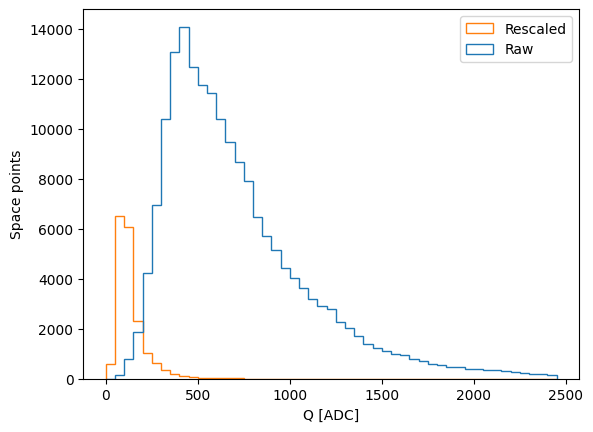

In [32]:
#Compare rescaled charge
raw_charge = event_nominal['input_data'].tensor[:, VALUE_COL]
rescaled_charge = event_nominal['cluster_label'].tensor[:, VALUE_COL]

plt.hist([raw_charge,rescaled_charge],label=['Raw','Rescaled']
         ,histtype='step'
         ,bins=np.arange(0,2500,50))
plt.legend()
plt.xlabel('Q [ADC]')
plt.ylabel('Space points');

In [33]:
#Compare unscaled and rescaled charge - why is the colorscale not working??
trace_unscaled = []
tpc_traces = GeoDrawer('sbnd').tpc_traces(draw_faces=False, linewidth=5)
trace_unscaled += scatter_points(event_nominal['input_data'].tensor[:, COORD_COLS][~ghost_mask], color=raw_charge[~ghost_mask], colorscale='Inferno', cmax=1500, cmin=0, markersize=1)
trace_unscaled[-1]['name'] = 'Raw charge (No ghost)'
# trace_unscaled += scatter_points(voxels_input, color=event['input_data'][:,5], colorscale='Inferno', cmax=10, markersize=1)
# trace_unsalced[-1]['name'] = 'Chi2'
trace_unscaled += tpc_traces

trace_rescaled = []
trace_rescaled += scatter_points(event_nominal['cluster_label'].tensor[:, COORD_COLS], color=rescaled_charge, colorscale='Inferno', cmax=500, cmin=0, markersize=1)
trace_rescaled[-1]['name'] = 'Rescaled charge'
trace_rescaled += tpc_traces

In [34]:
# Template cell for side-by-side event displays
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                    horizontal_spacing=0.05, vertical_spacing=0.04)

fig.add_traces(trace_unscaled, rows=len(trace_unscaled) * [1], cols=len(trace_unscaled) * [1])
fig.add_traces(trace_rescaled, rows=len(trace_rescaled) * [1], cols=len(trace_rescaled) * [2])

fig.layout = layout3d()
fig.update_layout(showlegend=True,
                  legend=dict(xanchor="left"),
                 autosize=True,
                 height=500,
                 width=1000,
                 margin=dict(r=20, l=20, b=20, t=20))
if MAKE_PLOTS:
    iplot(fig)
if SAVE_PLOTS:
    fig.write_image('figures/event_sbnd_comp_raw_rescaled.png')

## 4. Instances of Supera failing

When Supera fails, it's usually due to `trackID` being misassigned. So it's not a Supera issue, but usually a `trackID` issue that occurs during simulation.

In [70]:
print('I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R \n'*100)

I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this section but wrote "known bugs" and "solved bugs" sections here for reference - https://shortbaseline.slack.com/canvas/C05J07U1V1R 
I did not write code for this sect